<a href="https://colab.research.google.com/github/spe301/Clustering-Automobile-Customers/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Potosnail==0.0.9

In [ ]:
from potosnail import *
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

ml = MachineLearning()
dh = DataHelper()
ev = Evaluater()
st = Stats()

def GetTopN(df, var, n):
    dict(df[var].value_counts())
    X = list({v: k for k, v in dict(df[var].value_counts()).items()}.values())[:n]
    y = list({v: k for k, v in dict(df[var].value_counts()).items()}.keys())[:n]
    sns.barplot(X, y);
    plt.show()

def BinaryBarGraph(df, opt1, opt2, var):
    yes = len(df.loc[df[var] == opt1])/len(df)
    no = 1 - yes
    X = [opt1, opt2]
    y = [yes, no]
    sns.barplot(X, y);
    plt.show()
    return 'The sample is {}% {} and {}% {}'.format(int(round(yes*100)), opt1, int(round(no*100)), opt2)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
d1 = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Train.csv')
d2 = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Test.csv')
df = pd.concat([d1, d2]).drop(['ID', 'Var_1', 'Segmentation'], axis='columns').reset_index()

# How I'm going to go about this...

Scrub: I will clean this data so it can be interpreted by a model

Explore: I will draw insights and visualize the data

Model: build a Clustering model to segment the customers into 5 distinct segments, one for each product

# Scrub
## Filling in NaN values

In [ ]:
df['Ever_Married'] = df['Ever_Married'].fillna('No')
df['Graduated'] = df['Graduated'].fillna('No')
df['Profession'] = df['Profession'].fillna('None')
df['Work_Experience'] = df['Work_Experience'].fillna(int(np.mean(df['Work_Experience'])))
df['Family_Size'] = df['Family_Size'].fillna(int(round(np.mean(df['Family_Size']))))
df.isna().sum()

index              0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

In [ ]:
df = df.drop(['index'], axis='columns')
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,2.0,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,2.0,High,6.0


Converting gender, married, and graduated to 0's and 1's. However, I will also keep the original columns for Analysis purposes.

In [ ]:
lst = ['Gender', 'Ever_Married', 'Graduated']
keepers = df[lst]

In [ ]:
df2 = pd.concat([dh.Binarize(df, lst), keepers], axis='columns')
df2.columns = list(df2.columns)[:-3] + ['Gender_str', 'Married_str', 'Grad_str']
df2.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str
0,1,1,22,1,Healthcare,1.0,Low,4.0,Male,No,No
1,0,0,38,0,Engineer,2.0,Average,3.0,Female,Yes,Yes
2,0,0,67,0,Engineer,1.0,Low,1.0,Female,Yes,Yes
3,1,0,67,0,Lawyer,0.0,High,2.0,Male,Yes,Yes
4,0,0,40,0,Entertainment,2.0,High,6.0,Female,Yes,Yes


One Hot Encoding Profession, again I will hold onto the original column for Analysis purposes.

In [ ]:
df3 = pd.concat([df2, dh.OHE(df2['Profession'])], axis='columns')
df3.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None
0,1,1,22,1,Healthcare,1.0,Low,4.0,Male,No,No,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0,38,0,Engineer,2.0,Average,3.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,67,0,Engineer,1.0,Low,1.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,67,0,Lawyer,0.0,High,2.0,Male,Yes,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,40,0,Entertainment,2.0,High,6.0,Female,Yes,Yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Converting Spending Score to numerical data, this time I will drop the original column altogether bceause the data is rankable. (ie. 1 can represent low, 2 average, and so on)

In [ ]:
ss = df3['Spending_Score']
scores = []
for i in range(len(ss)):
    if ss[i] == 'Low':
        scores.append(1)
    if ss[i] == 'Average':
        scores.append(2)
    if ss[i] == 'High':
        scores.append(3)
        
df3['Spending_Score'] = scores

In [ ]:
df3.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None
0,1,1,22,1,Healthcare,1.0,1,4.0,Male,No,No,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0,38,0,Engineer,2.0,2,3.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,67,0,Engineer,1.0,1,1.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,67,0,Lawyer,0.0,3,2.0,Male,Yes,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,40,0,Entertainment,2.0,3,6.0,Female,Yes,Yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA questions

1. How is age distributed among different Spending Scores?
2. is the difference in spending score for married and unmarried customers statistically signifigant?
3. What are the most common professions among each spending score and how do they differ?

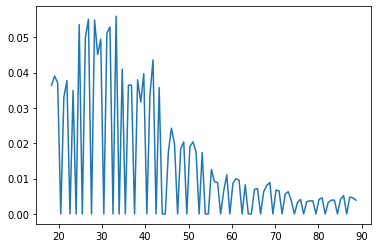

In [13]:
st.PDF(df3.loc[df3['Spending_Score'] == 1]['Age'])

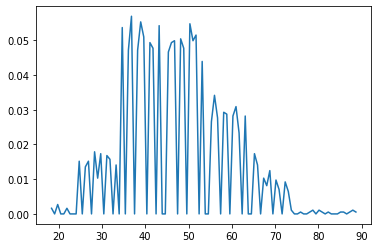

In [14]:
st.PDF(df3.loc[df3['Spending_Score'] == 2]['Age'])

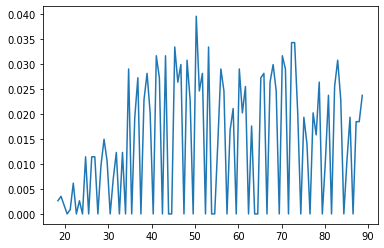

In [15]:
st.PDF(df3.loc[df3['Spending_Score'] == 3]['Age'])

Conclusion: Spending Scores tend to increase as age increases. Almost all customers with 'low' spending scores are under 50, and the distribution really dips off after 40.

Reccomendation: avoid marketing more expensive vehicles to people under 35-40.